# Creating Image Building Footprint Masks

Given a set of images downloaded from Planet, return a building footprint mask for each image; that is, for each image, return a numpy array with the same dimensions as the original image with values 1 if the pixel is a building, else 0. Ground truth is determined by the Microsoft Building Footprints Dataset. Purpose is to provide additional labels for the DSSG Building Segmentation Model.

Steps:
1. For each image, find all of the Microsoft Building Footprint Polygons that intersect with that image. **(15 seconds per image)**
    1. For each image, create a `Shapely.geometry.box` object using the corners of each image, and intersect that `Shapely.geometry.box` with Microsoft Building Footprints GeoDataFrame.
2. For each image, extract the latitude/longitude coordinates for each pixel **(1.5 minutes per image)**
    1. For each image, for loop over each pixel and finding the latitude/longitude coordinates of each pixel
3. Intersect each of the coordinates (from step 2) with the subset of polygons relevant for that image (from step 1) to return the image mask. **(2 seconds per image)**
    1. For each image, use GeoPandas.DataFrame.intersect

In [1]:
import datetime as dt

print(dt.datetime.now())

2020-08-03 04:00:54.480585


In [2]:
import glob
import os
import pickle
import random
import shutil
import subprocess
import sys

import gdal
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from osgeo import osr, gdal
import PIL
from PIL import Image, TiffImagePlugin
import rasterio
from rasterio.plot import show
from shapely.geometry import Point, Polygon, box

In [3]:
# For DSSG Microsoft VM
DATA_DIR = os.path.join('/home', 'dssg-reglab', 'notebooks', 'home')
MICROSOFT_FOOTPRINTS_RAW_DATA_DIR = os.path.join(DATA_DIR, 'data', 'raw', 'microsoft_building_footprints')
IMAGE_PATH_DIR = os.path.join(DATA_DIR, 'data', 'raw', 'planet_images_il-2019')  # This is what we'll want to change if we want to do command line arguments

RUN_CONVERT_MS_GEOJSON_TO_PICKLE = False
RUN_FIND_INTERSECTING_MS_POLYGONS_TO_IMAGE = False
RUN_CREATE_IMAGE_MASK = False

# Helper Functions
In this section, we'll define helper functions that we will call throughout the notebook.

In [4]:
def load_tiff_as_rgb(img_file, show_plot=True):
    with rasterio.open(img_file) as src:
        b,g,r,n = src.read()

    rgb = np.stack((r,g,b), axis=0)
    if show_plot:
        rasterio.plot.show(rgb / rgb.max())
    
    return rgb / rgb.max()

In [5]:
def get_lat_lon(img_path):
    """
    Return four pairs of lat longs which bound the img, which
    is in GeoTIFF format.

    Args:
        img_path (str): path to (geotiff) image file.

    Returns:
        [latlong_minx, latlong_miny, latlong_maxx, latlong_maxy]: latlon coordinates bounding the image.

    See https://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file as
    a useful reference. This was useful because Planet Imagery is first given in UTM Zone 15 coordinates
    so need to convert to latitude/longitude
    """
    ds = gdal.Open(img_path)
    old_cs = osr.SpatialReference()
    old_cs.ImportFromWkt(ds.GetProjectionRef())

    # create the new coordinate system
    # In this case, we'll use WGS 84
    wgs84_wkt = """
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]]"""
    new_cs = osr.SpatialReference()
    new_cs.ImportFromWkt(wgs84_wkt)

    # create a transform object to convert between coordinate systems
    transform = osr.CoordinateTransformation(old_cs,new_cs) 

    gt = ds.GetGeoTransform()

    width = ds.RasterXSize
    height = ds.RasterYSize

    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5]
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]

    #get the coordinates in lat long
    latlong_min = transform.TransformPoint(minx, miny) 
    latlong_max = transform.TransformPoint(maxx, maxy)

    latlong_minx = latlong_min[0]
    latlong_miny = latlong_min[1]
    latlong_maxx = latlong_max[0]
    latlong_maxy = latlong_max[1]

    return [latlong_minx, latlong_miny, latlong_maxx, latlong_maxy]

In [6]:
def find_intersecting_ms_polygons_to_image(image_filenames, ms_buildings_df, output_dir_basename):
    """
    Find all intersecting MS Polygons in image given by image_filename

    Keyword Args:
      - image_filenames: A List of all image filenames (tif) over which we will find the intersecting MS Building Footprints Polygons
      - ms_buildings_df: A GeoPandasDataframe that contains all the Microsoft Building Footprint Polygons
      - output_dir_basename: Basename of the output dir to put in ~/notebooks/home/data/processed

    Note, this takes about 15 seconds per image, so to process 200 images --> 50 minutes
    """
    # Dictionary to store for each image, the MS Buildings polygons that intersect with that image
    image_ms_buildings_intersect = {}
    for image_filename in image_filenames:
        print('Processing {}'.format(image_filename))
        
        # Find the Latitude and Longitude Coordinates of the corners of each image
        lat_lon_coordinates = get_lat_lon(img_path=image_filename)
        image_box = [box(lat_lon_coordinates[0], lat_lon_coordinates[1], lat_lon_coordinates[2], lat_lon_coordinates[3])]
        image_box_gpd = gpd.geoseries.GeoSeries(image_box)
        image_box_gpd_df = gpd.GeoDataFrame(image_box_gpd, columns = ['geometry'], geometry='geometry')

        # Intersect the corners of the image with the MS Building Footprints dataset to subset to the polygons that actually intersect with the image
        ms_buildings_intersect_df = ms_buildings_df.loc[ms_buildings_df.geometry.intersects(image_box_gpd.unary_union)].copy(deep=True)

        # Store the resulting dataframe into the dictionary
        image_ms_buildings_intersect[image_filename] = ms_buildings_intersect_df
    
    output_dir = os.path.join(DATA_DIR, 'data', 'processed', output_dir_basename)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with open(os.path.join(output_dir, 'image_ms_buildings_intersect' + '.pkl'), 'wb') as f:
        pickle.dump(image_ms_buildings_intersect, f)

    print('Success! Done Finding MS Polygons Intersect with Image. Wrote results to {}'.format(os.path.join(output_dir, 'image_ms_buildings_intersect.pkl')))
    return image_ms_buildings_intersect

In [7]:
def pixel2coord(img_path, x, y):
    """
    Returns latitude/longitude coordinates from pixel x, y coords

    Keyword Args:
      img_path: Text, path to tif image
      x: Pixel x coordinates. For example, if numpy array, this is the column index
      y: Pixel y coordinates. For example, if numpy array, this is the row index
    """
    # Open tif file
    ds = gdal.Open(img_path)

    old_cs = osr.SpatialReference()
    old_cs.ImportFromWkt(ds.GetProjectionRef())

    # create the new coordinate system
    # In this case, we'll use WGS 84
    # This is necessary becuase Planet Imagery is default in UTM (Zone 15). So we want to convert to latitude/longitude
    wgs84_wkt = """
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]]"""
    new_cs = osr.SpatialReference()
    new_cs.ImportFromWkt(wgs84_wkt)

    # create a transform object to convert between coordinate systems
    transform = osr.CoordinateTransformation(old_cs,new_cs) 
    
    gt = ds.GetGeoTransform()

    # GDAL affine transform parameters, According to gdal documentation xoff/yoff are image left corner, a/e are pixel wight/height and b/d is rotation and is zero if image is north up. 
    xoff, a, b, yoff, d, e = gt

    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff

    lat_lon = transform.TransformPoint(xp, yp) 

    xp = lat_lon[0]
    yp = lat_lon[1]
    
    return (xp, yp)


def find_img_coordinates(img_array, image_filename):
    """
    Find all latitude/longitude coordinates of each pixel in image

    Keyword Args:
      img_array: Image as an array
      image_filename: Path to tif image

    Returns: a list with the same dimensions as the original image where
    each element is a shapely.geometry.Point of the latitude/longitude of that pixel.
    """
    img_coordinates = np.zeros((img_array.shape[0], img_array.shape[1], 2)).tolist()
    for row in range(0, img_array.shape[0]):
        for col in range(0, img_array.shape[1]): 
            img_coordinates[row][col] = Point(pixel2coord(img_path=image_filename, x=col, y=row))
    return img_coordinates


def find_image_pixel_lat_lon_coord(image_filenames, output_filename):
    """
    Find latitude, longitude coordinates for each pixel in the image

    Keyword Args:
      image_filenames: A list of paths to tif images
      output_filename: A string specifying the output filename of a pickle file to store results

    Returns image_coordinates_dict whose keys are filenames and values are an array of the same shape as the image with each element being the latitude/longitude coordinates.
    """
    image_coordinates_dict = {}
    for image_filename in image_filenames:
        print('Processing {}'.format(image_filename))
        img = Image.open(image_filename)
        img_array = np.array(img)
        img_coordinates = find_img_coordinates(img_array=img_array, image_filename=image_filename)
        image_coordinates_dict[image_filename] = img_coordinates
        with open(os.path.join(DATA_DIR, 'interim', output_filename + '.pkl'), 'wb') as f:
            pickle.dump(image_coordinates_dict, f)
    return image_coordinates_dict

In [8]:
def create_image_mask(image_filenames, image_ms_buildings_intersect, output_dir_basename):
    """
    Creating final Image Mask for Building Pixels

    Keyword Args:
      image_filenames: List of paths to tif images
      image_ms_buildings_intersect: Dictionary Storing Polygons of MS Building Footprints that intersect with Image
      output_dir_basename: Basename of the output dir to put in ~/notebooks/home/data/processed
    
    Returns image_masks_dict whose keys are image_filename and value are the image masks (numpy array)
    """

    image_masks = {}
    for image_filename in image_filenames:
        print('Finding Building Mask for: {}'.format(image_filename))

        # Write a temporary GeoJSON file that is a subset of the larger MS GeoJSON with just the Polygons that intersect
        image_ms_buildings_intersect[image_filename].to_file(
            os.path.join(DATA_DIR, 'data', 'processed', output_dir_basename, 'input_shapefile_fn.geojson'))

        target_fn = image_filename
        input_shapefile_fn = os.path.join(DATA_DIR, 'data', 'processed', output_dir_basename, 'input_shapefile_fn.geojson')
        output_fn = os.path.join(os.path.join(DATA_DIR, 'data', 'processed', output_dir_basename, 'building_mask.tif'))


        f = rasterio.open(target_fn, "r")
        left, bottom, right, top = get_lat_lon(target_fn)
        crs = f.crs.to_string()
        height, width = f.height, f.width
        f.close()

        command = [
            "gdal_rasterize",
            "-ot", "Byte",
            "-burn", "1.0",
            "-of", "GTiff",
            "-te", str(left), str(bottom), str(right), str(top),
            "-ts", str(width), str(height),
            "-co", "COMPRESS=LZW",
            "-co", "BIGTIFF=YES",
            input_shapefile_fn,
            output_fn
        ]
        proc = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        proc.wait()

        (stdout, stderr) = proc.communicate()

        if proc.returncode != 0:
            print(stderr)
        else:
            print('Done Finding Building Mask for: {}'.format(image_filename))

        print('Saving Result to image_masks dictionary')
        with rasterio.open(output_fn) as src:
            mask = src.read()
        image_masks[image_filename] = mask

    print('Saving Image Masks as Pickled Dictionary')
    with open(os.path.join(DATA_DIR, 'data', 'processed', output_dir_basename, 'image_masks.pkl'), 'wb') as f:
        pickle.dump(image_masks, f)
    
    # Remove the temporary files
    if os.path.exists(input_shapefile_fn):
        shutil.rmtree(input_shapefile_fn)
    if os.path.exists(output_fn):
        os.remove(output_fn)
    return image_masks



# Create Microsoft Building Footprint Pickle File
Due to the size of the Microsoft geojson data, it takes a long time to fully read the geojson file. According to this [StackOverflow](https://stackoverflow.com/questions/37010212/what-is-the-fastest-way-to-upload-a-big-csv-file-in-notebook-to-work-with-python) post, reading from a pickle file can be much quicker, so once we produce the pickle files, we don't have to read the raw geojson files again.


In [9]:
def write_pkl_from_geojson(filename, input_dir, output_dir):
    """
    Helper function to write pkl file of a GeoPandas DataFrame after reading from GeoJson
    
    Keyword Args:
        - filepath: Filepath to GeoJSON file. 
    """
    print('Reading in GeoJSON file as a GeoPandas DataFrame')
    df = gpd.read_file(os.path.join(input_dir, filename + '.geojson'))
    
    print('Finished reading GeoJSON file, begin outputting GeoPandas DataFrame as a pickle object')
    df.to_pickle(os.path.join(output_dir, filename + '.pkl'))
    
    print('Done writing as a pickle!')

In [10]:
if RUN_CONVERT_MS_GEOJSON_TO_PICKLE:
    write_pkl_from_geojson(
        'Illinois',
        input_dir=os.path.join(MICROSOFT_FOOTPRINTS_RAW_DATA_DIR),
        output_dir=MICROSOFT_FOOTPRINTS_RAW_DATA_DIR
    )

# Read in Example Image File

In [11]:
example_image_path = os.path.join(DATA_DIR, 'data', 'raw', 'planet_images_il-2020', 'planet_loc_078-date_2020-07-01.tif')

In [12]:
example_image_path

'/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2020/planet_loc_078-date_2020-07-01.tif'

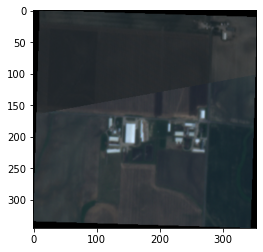

In [13]:
img_arr = load_tiff_as_rgb(example_image_path)

In [14]:
np.array(img_arr).shape

(3, 345, 354)

# Find all Microsoft Building Footprints Polygon that Intersect with Image

In [15]:
ms_buildings_il_df = pickle.load(open(os.path.join(MICROSOFT_FOOTPRINTS_RAW_DATA_DIR, 'Illinois.pkl'), "rb" ))

In [16]:
ms_buildings_il_df.head()

,geometry
0,"POLYGON ((-89.98166 42.49725, -89.98172 42.497..."
1,"POLYGON ((-89.98279 42.49825, -89.98279 42.498..."
2,"POLYGON ((-89.99911 42.49435, -89.99911 42.494..."
3,"POLYGON ((-89.99998 42.49550, -89.99970 42.495..."
4,"POLYGON ((-89.98399 42.48850, -89.98414 42.488..."


In [17]:
ms_buildings_il_df.shape

(4855794, 1)

In [18]:
image_path_dir_basename = os.path.basename(IMAGE_PATH_DIR)
image_filenames = glob.glob(os.path.join(IMAGE_PATH_DIR, '*.tif'))
print(type(image_filenames), len(image_filenames))

<class 'list'> 229


In [19]:
# This takes about 15 seconds per image --> processing 200 images is about 1 hour
if RUN_FIND_INTERSECTING_MS_POLYGONS_TO_IMAGE:
    image_ms_buildings_intersect = find_intersecting_ms_polygons_to_image(
        image_filenames=image_filenames, ms_buildings_df=ms_buildings_il_df, output_dir_basename=image_path_dir_basename)
else:
    image_ms_buildings_intersect = pickle.load(open(os.path.join(DATA_DIR, 'data', 'processed', image_path_dir_basename, 'image_ms_buildings_intersect.pkl'), "rb" ))

In [20]:
type(image_ms_buildings_intersect)

dict

# Creating Image Mask
Microsoft AI For Good Team has already created some tools to rasterize against a shapefile or GeoJson File. See [this GitHub]( https://github.com/microsoft/ai4eutils/blob/master/geospatial/recipes_and_guides/geospatial_recipes.md#rasterize-shapefile-to-the-exent-of-a-raster) for more details.

In [21]:
if RUN_FIND_INTERSECTING_MS_POLYGONS_TO_IMAGE:
    image_masks = create_image_mask(
        image_filenames=image_filenames,
        image_ms_buildings_intersect=image_ms_buildings_intersect,
        output_dir_basename=image_path_dir_basename
    )
else:
    image_masks = pickle.load(open(os.path.join(
        DATA_DIR, 'data', 'processed', image_path_dir_basename, 'image_masks.pkl'), "rb" ))
    

In [22]:
len(list(image_masks.keys()))

221

In [23]:
image_masks.keys()

dict_keys(['/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_008-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_097-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_170-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_179-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_076-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_080-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_160-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_192-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_136-date_2019-07-01.tif', '/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet

# Checking Results

In [24]:
filename_check = random.choice(list(image_masks.keys()))

In [25]:
image_ms_buildings_intersect[filename_check]

,geometry
239781,"POLYGON ((-88.90715 41.78441, -88.90714 41.784..."
286582,"POLYGON ((-88.90772 41.78538, -88.90772 41.785..."
753133,"POLYGON ((-88.90754 41.78489, -88.90741 41.784..."
2060566,"POLYGON ((-88.90087 41.78962, -88.90087 41.789..."
2293418,"POLYGON ((-88.90797 41.78473, -88.90765 41.784..."
2293419,"POLYGON ((-88.90797 41.78529, -88.90797 41.785..."
2994078,"POLYGON ((-88.90787 41.78507, -88.90754 41.785..."
3180778,"POLYGON ((-88.90712 41.78469, -88.90702 41.784..."
3367348,"POLYGON ((-88.90713 41.78562, -88.90744 41.785..."
3881280,"POLYGON ((-88.90784 41.78462, -88.90805 41.784..."


/home/dssg-reglab/notebooks/home/data/raw/planet_images_il-2019/planet_loc_034-date_2019-07-01.tif


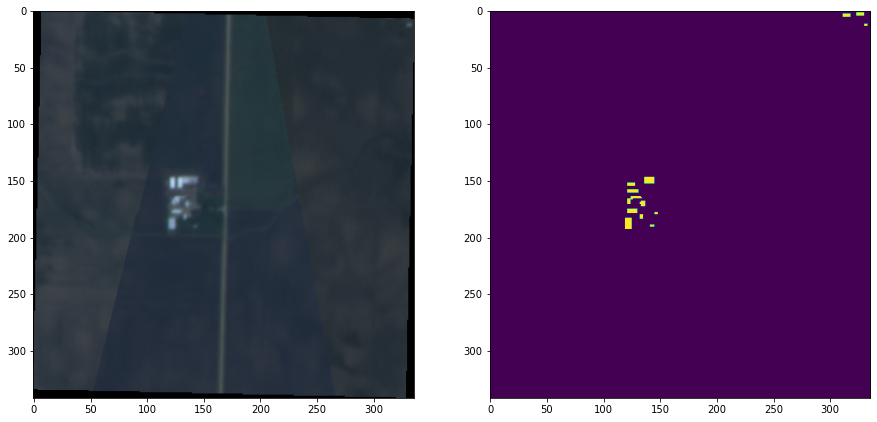

In [26]:
print(filename_check)
fig, ax_lst = plt.subplots(1, 2, figsize=(15, 8))
ax_lst = ax_lst.ravel()
img = load_tiff_as_rgb(filename_check, show_plot=False)
rasterio.plot.show(img, ax=ax_lst[0])
rasterio.plot.show(image_masks[filename_check], ax=ax_lst[1])